In [1]:
import open3d as o3d
import numpy as np
import os
import cv2
import copy
import matplotlib.pyplot as plt
from scipy.io import wavfile
import sys

storage_path = "data/"
isRunning = True
filename_strs = [
    "box_paper",
    "box_paper_withangle",
    "iron_rect_black_withangle",
    "iron_rect1_black",
]
sys.path.append("../dependencies/FastSAM/")


def key_callback(vis, action, mods):
    global isRunning
    if action == 0:
        isRunning = False


lis_coords = [[0, 0, 0.5], [0, 0, 0.6], [0, 0, 0.54], [0, 0, 0.4]]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
idx = 3
image_sz = 1024  # 输入网络的图片大小 越小速度越快
save_plot = False
model_name = "x"  # s or x
save_pts = True

H:  360  W:  640


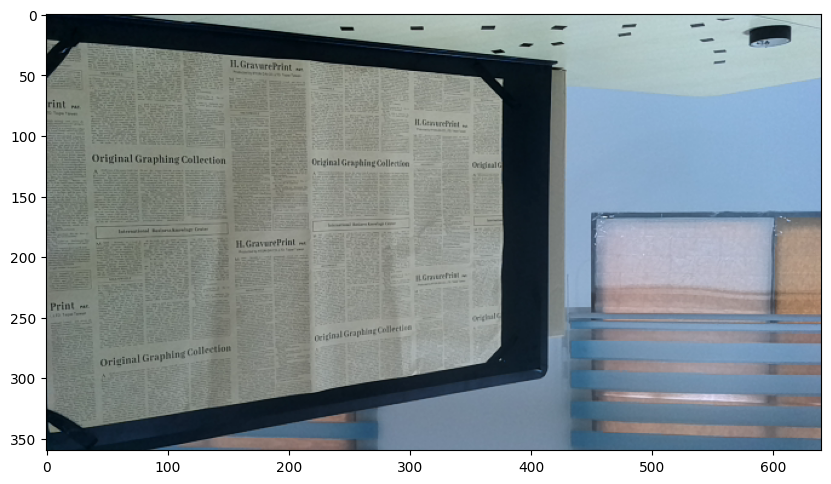

In [3]:
idx -= 1
pt_data = np.load(f"../data/{filename_strs[idx]}.npz")
points = pt_data["points"] / 1000  # 转换格式
colors = pt_data["colors"]
points[:, -1] += 0.02  # 误差修正
# 建立点云
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

Height = 40 * 9
Width = 40 * 16
channels = 3
assert Height * Width == points.shape[0]

# 查看图片
rescale_colors = 255 * colors
rescale_colors = rescale_colors.astype(np.uint8).reshape((Height, Width, channels))

print("H: ", rescale_colors.shape[0], " W: ", rescale_colors.shape[1])
plt.figure(figsize=(10, 10))
plt.imshow(rescale_colors)

In [4]:
from fastsam import FastSAM, FastSAMPrompt
import torch

temp_name = filename_strs[idx] + f"_fastsam_{model_name}_{image_sz}"

model = FastSAM(f"../models/FastSAM-{model_name}.pt")
image_path = rescale_colors
device = "cpu"
everything_results = model(
    image_path,
    device=device,
    retina_masks=True,
    imgsz=image_sz,
    conf=0.4,
    iou=0.9,
)
container = everything_results[0].masks.data
sum_per_mask = torch.sum(container, dim=(1, 2))
sorted_indices = torch.argsort(sum_per_mask, descending=True)
shapes = everything_results[0].masks.data.shape
everything_results[0].masks.data = everything_results[0].masks.data[sorted_indices[0]]
everything_results[0].masks.data = everything_results[0].masks.data.reshape(
    1, shapes[1], shapes[2]
)

print(f"Detected {len(everything_results[0])} items.")


0: 576x1024 17 objects, 689.0ms
Speed: 1.5ms preprocess, 689.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)


Detected 17 items.


640 360


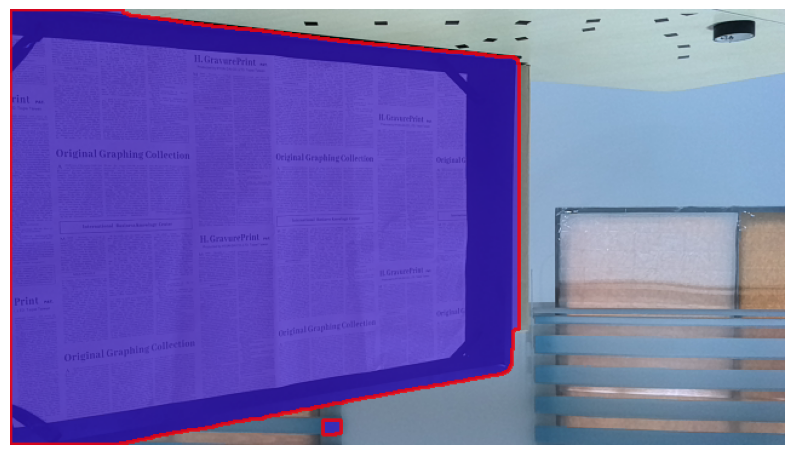

In [5]:
# use no extra prompt
prompt_process = FastSAMPrompt(image_path, everything_results, device=device)
ann = prompt_process.everything_prompt()
annotated_img = prompt_process.plot_to_result(annotations=ann)
if save_plot:
    prompt_process.plot(
        annotations=ann,
        output_path="./output/" + temp_name + ".png",
    )


image = annotated_img
original_h = image.shape[0]
original_w = image.shape[1]
print(original_w, original_h)
plt.figure(figsize=(10, 10))
plt.axis("off")

plt.imshow(image)

In [6]:
everything_results[0].masks.data.shape

torch.Size([1, 360, 640])

In [7]:
pcd_masked = o3d.geometry.PointCloud()
numpy_mask1 = everything_results[0].masks.data.numpy()
numpy_mask1 = numpy_mask1.flatten()
numpy_mask2 = np.array(pcd.points)[:, 2] <= 1.5
numpy_mask = np.logical_and(numpy_mask1, numpy_mask2)
pcd_masked.points = o3d.utility.Vector3dVector(np.array(pcd.points)[numpy_mask])
pcd_masked.colors = o3d.utility.Vector3dVector(np.array(pcd.colors)[numpy_mask])

In [8]:
# view masked pts
isRunning = True
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()
vis.register_key_action_callback(81, key_callback)
coordinateFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=1, origin=[0, 0, 0]
)
vis.add_geometry(coordinateFrame)

vis.add_geometry(pcd_masked)
vis.poll_events()
vis.update_renderer()
while isRunning:
    key = cv2.waitKey(1)
    vis.update_geometry(pcd_masked)
    if key == ord("q"):
        break

    vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

In [9]:
if save_pts:
    np.savez(
        f"./output/{temp_name}.npz",
        points=np.array(pcd_masked.points),
        colors=np.array(pcd_masked.colors),
    )
print("Avg Z dist: ", np.array(pcd_masked.points)[:, -1].mean())

Avg Z dist:  0.9418473829573256


Successfully write possion obj file

numDirectRays: 200
maxSpecularDepth: 200
numSpecularRays: 20000
numSpecularSamples: 100
maxDiffuseDepth: 200
numDiffuseRays: 2000000
numDiffuseSamples: 3
maxDiffractionDepth: 0
maxDiffractionOrder: 3
responseTime: 5
visibilityCacheTime: 5
rayOffset: 0.0001
numThreads: 8
minQuality: 0.25
maxQuality: 1.5
quality: 1
Amplitutde pulse 15 strongest idx: [ 75 203 196 206 200  78 227 204 201 205 194  77 208 230 198]
Execute time in function mesh and trace: 860438 ms. Trace using 2228 ms.
sample rate:  48000


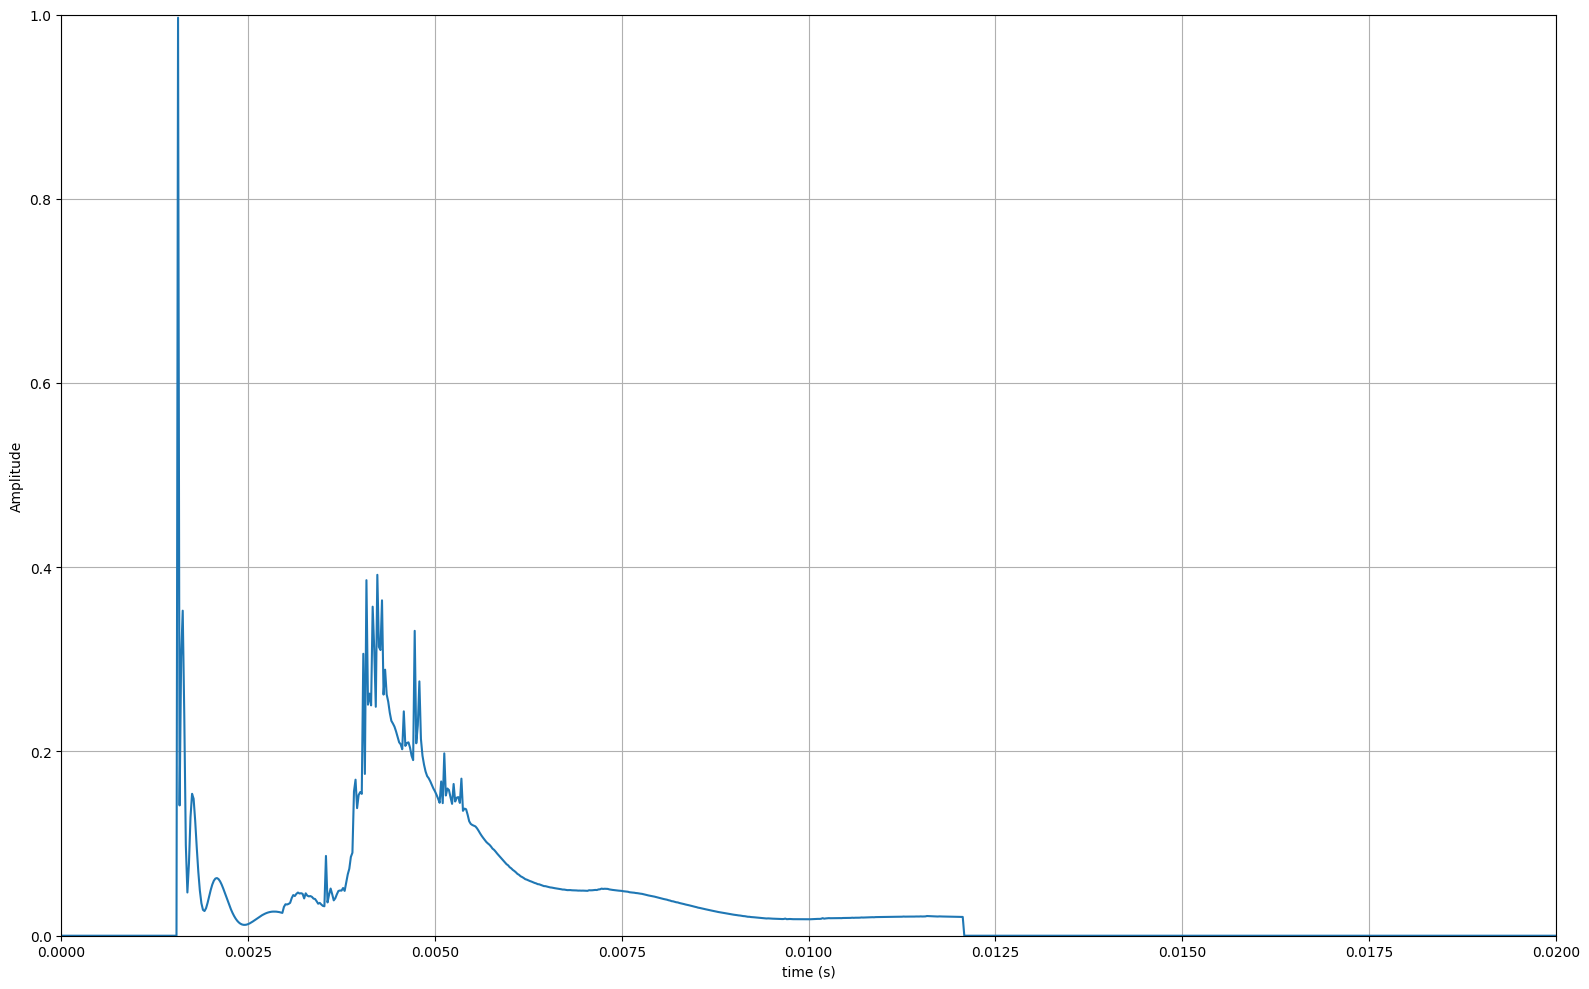

In [10]:
import gsound

result = gsound.mesh_and_trace(
    pcd_masked, lis_coord=lis_coords[idx], view_in_process=True
)
print("sample rate: ", result[1])
gsound.pygsound_plot(
    result[0], result[1], save_plot=True, file_name=f"IR{idx+1}_late_" + temp_name
)

In [11]:
# 下面开始平面坐标确定 RANSAC 和光线追踪
import RANSAC
import ray_tracing


def generate_surface(pcd_masked, RANSAC_hyper):
    surface_eq = RANSAC.get_plane_info(
        point_cloud=np.array(pcd_masked.points),
        threshold=RANSAC_hyper[0],
        min_inliers_ratio=RANSAC_hyper[1],
    )
    points_xy = np.array(pcd_masked.points)[:, :2]
    points_xz = np.array(pcd_masked.points)[:, (0, 2)]
    points_yz = np.array(pcd_masked.points)[:, 1:]

    xy_bound = ray_tracing.extract_boundary_points(points_xy)
    xz_bound = ray_tracing.extract_boundary_points(points_xz)
    yz_bound = ray_tracing.extract_boundary_points(points_yz)

    surface_eq = tuple(surface_eq)
    xy_bound = [(float(x[0]), float(x[1])) for x in xy_bound]
    yz_bound = [(float(x[0]), float(x[1])) for x in yz_bound]
    xz_bound = [(float(x[0]), float(x[1])) for x in xz_bound]
    return [[surface_eq, xy_bound, xz_bound, yz_bound]]


params = {}
params["A"] = [0.01, 0.5]  # 对于1,3,4idx的RANSAC
params["B"] = [0.015, 0.5]  # 对于2 idx
params["C"] = [0.016, 0.65]
if (idx + 1) == 2:
    RANSAC_hyper = params["B"]
elif (idx + 1) == 3:
    RANSAC_hyper = params["C"]
else:
    RANSAC_hyper = params["A"]

surface_eq = RANSAC.get_plane_info(
    point_cloud=np.array(pcd_masked.points),
    threshold=RANSAC_hyper[0],
    min_inliers_ratio=RANSAC_hyper[1],
)

RANSAC 未能找到满足条件的平面。最佳内点数量为 71963 (要求至少 86607.3)。

--- RANSAC 估计结果 ---
估计平面方程: -0.4082x + 0.0518y + 0.9114z + -0.9360 = 0
内点数量: 71963
最大内点距离: 0.0160
所有内点距离是否小于阈值: True
估计平面法向量: [-0.4082, 0.0518, 0.9114]
法向量模长（应接近1）: 1.0000


In [12]:
surface_info = generate_surface(pcd_masked, RANSAC_hyper)

RANSAC 未能找到满足条件的平面。最佳内点数量为 71987 (要求至少 86607.3)。

--- RANSAC 估计结果 ---
估计平面方程: 0.3952x + -0.0528y + -0.9171z + 0.9410 = 0
内点数量: 71987
最大内点距离: 0.0160
所有内点距离是否小于阈值: True
估计平面法向量: [0.3952, -0.0528, -0.9171]
法向量模长（应接近1）: 1.0000


In [13]:
ray_tracing.simple_trace(surface_info, np.array(lis_coords[idx]))

search for 200000 rays
intersect_1_cnt: 12987
intersect_2_cnt: 0
find 127 valid paths
peaks found: [121, 121, 121, 121, 121, 121, 121, 120, 121, 121, 120, 121, 120, 120, 121, 120, 120, 120, 120, 121, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 120, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 121, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 120, 120, 120, 120, 121, 120, 120, 121, 120, 121, 121, 120, 120, 121, 121, 120, 121, 121, 121, 121, 121, 121]
ray tracing, ray num 200000, run time: 3285.3338718414307 ms.


array([120])